# <b>PART 1 : CNN classifier - VGG16 based</b>


* We will implement the CNN model - VGG16.
* Training data set: <b>COW HORSE</b> (3 X 256 X 256)

#### <b>Calling libraries</b>

* We will call pytorch library for the practice.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os.path 
import cv2
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

### <b>Hyperparameters definitions<b>

* We define Hyper parameters

* Function to display images from dataset

In [ ]:
# Device configuration for calculation, GPU used for faster calculation
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

# Hyper-parameters 
num_epochs = 50
batch_size = 4
learning_rate = 0.005
classes = ('cow', 'horse')

# Define transform function
transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def imshow(img,title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()



### <b>VGG16 based model implementation<b>

* Adapt input size according to our model as shown in the picture
* Convolution size formula : (W-F + 2*P)/S + 1 
* 2nd convolution layer we use kernel size = 17 to fit the size (256-34+0)/1+1 = 112

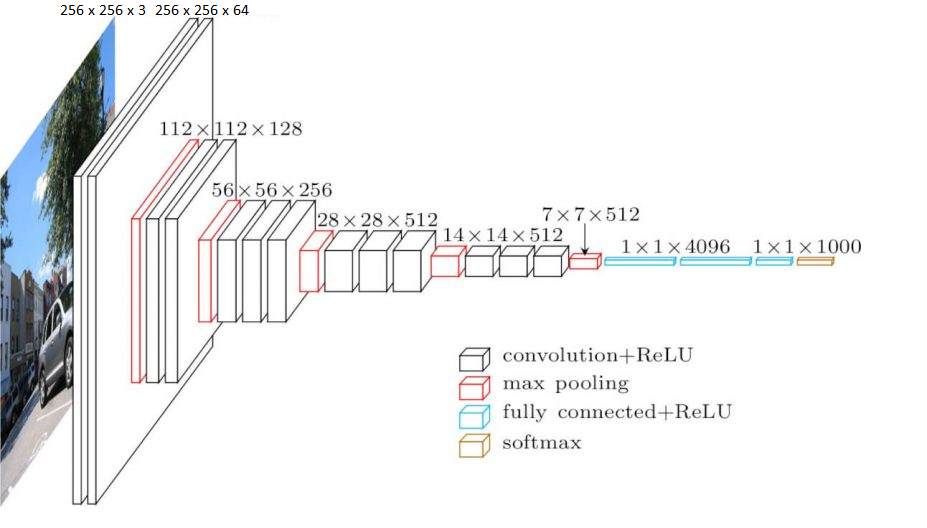

In [ ]:
class ConvNet(nn.Module):
  #convolution size formula (W - F + 2*P)/S + 1
    def __init__(self): #initialize function names
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), #(256-3+2)/1+1 = 256
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=17, stride=2, padding=0), #(256-34+0)/1+1 = 112
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18432, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=2, bias=True), #2 classes - Horse and Cow at the end
          )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        #x = x.view(-1, 512 * 6 * 6)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

####<b>Display all layers of  model in detail<b>

In [ ]:
from torchsummary import summary
#showing all layers in detail
model = ConvNet().to(device)
print(model)

summary(model, input_size=(3, 256, 256), device=device.type)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(17, 17), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
 

###<b>Training and testing the model<b>

* **train_model function**

We go through all files from the training dataset and judge our model.
We use CrossEntropy to measure the loss of the model and apply change in weights thanks to backward propagation.
We do this n times 

* **test_model function**

We go through all files from the test dataset and judge our model.
We calculate the overall accuracy of the model (good answer / all test)
we calculate the accuracy for each classes

In [ ]:
###################################### Training of CNN ################################
def train_model(train_loader,model, criterions, optimizer, epochs=25):
    since = time.time()
    n_total_steps = len(train_loader)
    for epoch in range(epochs):
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device) #loading into GPU
          labels = labels.to(device)
          #print(i)
          
          # Forward pass
          #print(images.shape)
          outputs = model(images)
          #print(outputs)
          myloss = criterions(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          myloss.backward()
          optimizer.step()

      print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {myloss.item():.4f}')

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)

    return model

##################################### Testing of CNN ########################################
def test_model (test_loader,model):
  with torch.no_grad():
    #initialisation of all the metric
      n_correct = 0
      n_samples = 0
      acc=0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]

    # test of CNN we load test images in GPU

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images) # we submit the test images to our trained Model
          # max returns (value ,index)
          _, predicted = torch.max(outputs, 1) #we save the prediction class value 
          print(labels,predicted)
          n_samples += labels.size(0) #for each sample tested we increase the value of sample tested (usefull for accuracy calculation)
          n_correct += (predicted == labels).sum().item()  #everytime we predict the good value we increase score 

          for i in range(images.shape[0]):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples 
      print(f'Accuracy of the network: {acc} %')

      for i in range(2):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc} %')


####<b>Training and testing a CNN with normal dataset<b>

Goal is to show that if we train a CNN with normal dataset, we will have poor results

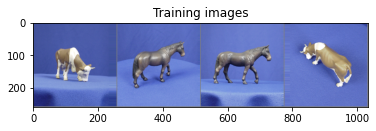

Epoch [1/50], Step [21/21], Loss: 0.3754
Epoch [2/50], Step [21/21], Loss: 0.0383
Epoch [3/50], Step [21/21], Loss: 1.1967
Epoch [4/50], Step [21/21], Loss: 0.5310
Epoch [5/50], Step [21/21], Loss: 0.0017
Epoch [6/50], Step [21/21], Loss: 0.0195
Epoch [7/50], Step [21/21], Loss: 0.0152
Epoch [8/50], Step [21/21], Loss: 0.0176
Epoch [9/50], Step [21/21], Loss: 0.0034
Epoch [10/50], Step [21/21], Loss: 0.0017
Epoch [11/50], Step [21/21], Loss: 0.2468
Epoch [12/50], Step [21/21], Loss: 0.0009
Epoch [13/50], Step [21/21], Loss: 0.0003
Epoch [14/50], Step [21/21], Loss: 0.0002
Epoch [15/50], Step [21/21], Loss: 0.0007
Epoch [16/50], Step [21/21], Loss: 0.0003
Epoch [17/50], Step [21/21], Loss: 0.0004
Epoch [18/50], Step [21/21], Loss: 0.0013
Epoch [19/50], Step [21/21], Loss: 0.0003
Epoch [20/50], Step [21/21], Loss: 0.0007
Epoch [21/50], Step [21/21], Loss: 0.0161
Epoch [22/50], Step [21/21], Loss: 0.0069
Epoch [23/50], Step [21/21], Loss: 0.0009
Epoch [24/50], Step [21/21], Loss: 0.0001
E

In [ ]:
#project1 is original dataset for work

train_dataset = torchvision.datasets.ImageFolder(root='./drive/MyDrive/data/Project1/ORIGINAL_DATASET/Train',transform=transformation)
test_dataset = torchvision.datasets.ImageFolder(root='./drive/MyDrive/data/Project1/ORIGINAL_DATASET/Test',transform=transformation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images),"Training images")

#Train model and Test model
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model_myvgg = train_model(train_loader, model, criterion, optimizer, epochs=50)
print("Start evaluating(testing) model")
test_model(test_loader, model_myvgg)

####<b>Training and testing a CNN with enhanced dataset<b>

Goal is to show that if we train a CNN with a dataset enhanced by our GAN, we expect better results


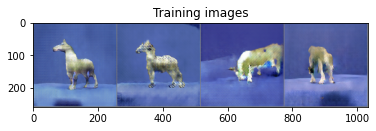

Epoch [1/50], Step [45/45], Loss: 3.6588
Epoch [2/50], Step [45/45], Loss: 0.1303
Epoch [3/50], Step [45/45], Loss: 0.0775
Epoch [4/50], Step [45/45], Loss: 0.0017
Epoch [5/50], Step [45/45], Loss: 0.7983
Epoch [6/50], Step [45/45], Loss: 0.0021
Epoch [7/50], Step [45/45], Loss: 0.0006
Epoch [8/50], Step [45/45], Loss: 0.0029
Epoch [9/50], Step [45/45], Loss: 0.0041
Epoch [10/50], Step [45/45], Loss: 0.0000
Epoch [11/50], Step [45/45], Loss: 0.0004
Epoch [12/50], Step [45/45], Loss: 0.0002
Epoch [13/50], Step [45/45], Loss: 0.0011
Epoch [14/50], Step [45/45], Loss: 0.0004
Epoch [15/50], Step [45/45], Loss: 0.0077
Epoch [16/50], Step [45/45], Loss: 0.4194
Epoch [17/50], Step [45/45], Loss: 0.0002
Epoch [18/50], Step [45/45], Loss: 0.0002
Epoch [19/50], Step [45/45], Loss: 0.0003
Epoch [20/50], Step [45/45], Loss: 0.0000
Epoch [21/50], Step [45/45], Loss: 0.0003
Epoch [22/50], Step [45/45], Loss: 0.0005
Epoch [23/50], Step [45/45], Loss: 0.0000
Epoch [24/50], Step [45/45], Loss: 0.0002
E

In [ ]:
#Project2 is oriiganl dataset + GAN dataset

train_dataset = torchvision.datasets.ImageFolder(root='./drive/MyDrive/data/Project2/GAN_ENHANCED_DATASET/Train',transform=transformation)
test_dataset = torchvision.datasets.ImageFolder(root='./drive/MyDrive/data/Project2/GAN_ENHANCED_DATASET/Train',transform=transformation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images),"Training images")

#Train model and Test model
model_enhanced = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_enhanced = torch.optim.SGD(model_enhanced.parameters(), lr=learning_rate)

model_myvgg_enhanced = train_model(train_loader, model_enhanced, criterion, optimizer_enhanced, epochs=50)
print("Start evaluating(testing) model")
test_model(test_loader, model_myvgg_enhanced)

# <b>PART 2 :GAN data augmentation</b>

* We will implement the DCGAN for the data agumentation
* We will generate horse and cow using additional dataset
* For the discriminator, pre-trained Resnet50 is used

In [ ]:
%ls
%cd ./drive/MyDrive/Project_MV/GAN/src

drive/  sample_data/
/content/drive/MyDrive/Project_MV/GAN/src


### <b>Calling libraries</b>

* Import pytorch libraries

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import torchvision
import matplotlib
from utils import save_generator_image, weights_init
from utils import label_fake, label_real, create_noise
from dcgan import Generator, Discriminator
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
matplotlib.style.use('ggplot')
import random

## <b>Extract of UTILS function<b>

In [ ]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### <b>Function to call pre-trained Resnet18</b>

* For GAN discriminator, we can call Resnet18 pre-trained  with ImageNet from Pytorch library
* We add a fc layer at the end, the size is '1' because goal of Discriminator is to check if generated image is real or fake


In [ ]:
def resnet_call(pretrained=True):
  resnet_model = models.resnet18(pretrained)
  NUM_FEAT = resnet_model.fc.in_features #Number of output features in our model 
  discriminator_output = 1 #Discriminator judges if data is fake or real
  resnet_model.fc = nn.Linear(NUM_FEAT, discriminator_output) #To make link between the fc of the loaded model and with number of label for our use
  return resnet_model

### <b> Function to create Dataset for GAN</b>

* Goal is to create a Dataset that will be used by disciminator to learn.

In [ ]:
def createGAN_traindataset(batch_size,workers=2,image_size=256,animal = "COW"):
  '''
  createGAN_traindataset is a function that creates a Dataset that will be used by discriminator to learn
  - batch_size : batch size to compute
  - workers : number of workers, default value is 2
  - image_size : Size of image accepted by discriminator, default value is 256
  - animal : can be "COW" or "HORSE", default value is "COW" 
  '''

  datapath = '/content/drive/MyDrive/Project_MV/GAN/Data/Train/Cow_tf'
  if (animal == "HORSE"):
    datapath = '/content/drive/MyDrive/Project_MV/GAN/Data/Train/Horse_tf'

  ################# image transforms ########################
  transformation = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.Resize([image_size,image_size]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), 
      (0.5, 0.5, 0.5)),
  ])

  ################ Load the dataset########################
  train_data = torchvision.datasets.ImageFolder(root=datapath,transform=transformation)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=workers)

  return train_data,train_loader

### <b> GAN architecture</b>
* Definition of Class Generator (Picture below) : DCGAN based structure
* Discriminator for pre-trained Resnet18

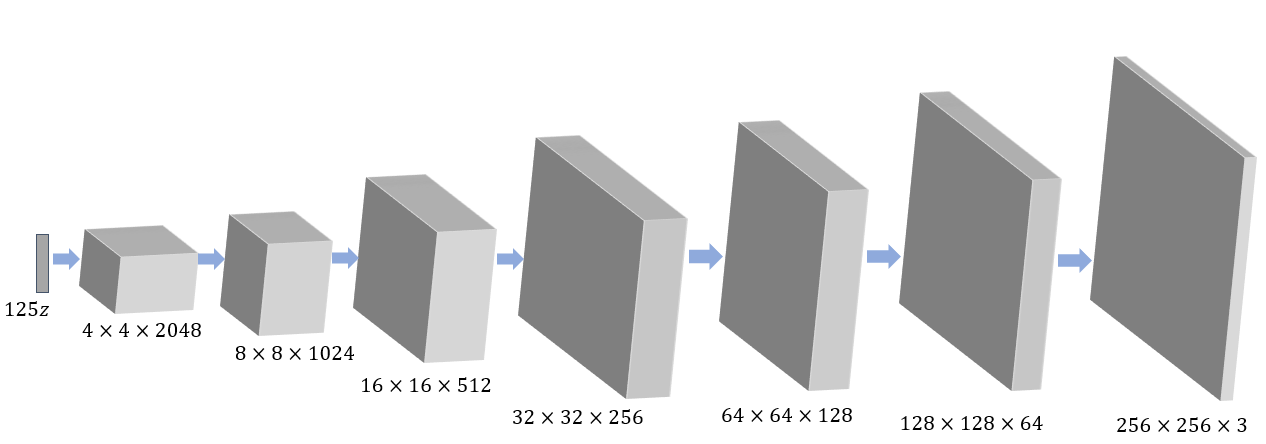

In [ ]:
############## generator################
#for generator, we have bias=False for every layer
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        #nz is the size of the noise vector that the generator will use as the input
        #It is a 125-dimensional noise vector as the input to the generator
        self.nz = nz
        #Sequential container to build the generator model
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            #With each subsequent convolution operation, we keep on reducing the output channels.
            #2048-->1024 => 512 => 256 => 128 => 64 => 3(RGB)
            nn.ConvTranspose2d(
            nz, 2048, kernel_size=4, 
            stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(True),
             nn.ConvTranspose2d(
                2048, 1024, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            #All of the four convolutions have a stride of 2 and a padding of 1 with 4×4 kernel
            nn.ConvTranspose2d(
                1024, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            #Only the last convolution has Tanh activation instead of ReLu
            nn.Tanh()
        )
    #forward() function makes a forward pass of the noise vector throuugh the generator network.
    #It returns generated output    
    def forward(self, input):
        return self.main(input)

###<b> Training GAN model <b>
* We can load the weight of previously trained
* Optimizer : ADAM optimizer is used
* Loss : BCE(binary classification loss)

In [ ]:
def training_GAN(nz,device,epochs,train_data,train_loader,animal = "COW",saving_image = False, pretrained = False):
  '''
  training_GAN is function that allow traning of DCGAN
  - nz : noize latent vector
  - device :
  - pretrained :
  '''

  ################Initialize model####################
  resnet_model = resnet_call()
  discriminator = resnet_model.to(device) 

  generator = Generator(nz).to(device)

  ###########initialize generator weights#############

  # load weights of previous trainings
  if (pretrained == True and animal =="COW"):
    generator.load_state_dict(torch.load('../input/weights/cow/generator_weights.pth'))
    discriminator.load_state_dict(torch.load('../input/weights/cow/disciminator_weights.pth'))
  if (pretrained == True and animal =="HORSE"):
    generator.load_state_dict(torch.load('../input/weights/horse/generator_weights.pth'))
    discriminator.load_state_dict(torch.load('../input/weights/horse/disciminator_weights.pth'))
  if(pretrained == False) :
    generator.apply(weights_init)
    discriminator.apply(weights_init)


  #print('##### GENERATOR #####')
  #print(generator)
  #print('######################')
  #print('\n##### DISCRIMINATOR #####')
  #print(discriminator)
  #print('######################')

  ############## Define Optimizers ###################
  optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

  ############## Define  loss function ###############
  criterion = nn.BCELoss()
  m = nn.Sigmoid()
  losses_g = [] # to store generator loss after each epoch
  losses_d = [] # to store discriminator loss after each epoch


  ##############TRAIN FUNCTION  ################

  # function to train the discriminator network
  def train_discriminator(optimizer, data_real, data_fake):
      flag = 0
      b_size = data_real.size(0)
      # get the real label vector according to batch size
      real_label = label_real(b_size)
      # get the fake label vector according to batch size
      fake_label = label_fake(b_size)
      optimizer.zero_grad()
      # get the outputs by doing real data forward pass
      output_real = discriminator(data_real).view(-1,1)
      #print(output_real)
      loss_real = criterion(m(output_real), real_label)
      # get the outputs by doing fake data forward pass
      output_fake = discriminator(data_fake).view(-1,1)
      if (torch.max(output_fake)>0): ######
        flag =(output_fake.argmax()) ######
      loss_fake = criterion(m(output_fake), fake_label)
      # compute gradients of real loss 
      loss_real.backward()
      # compute gradients of fake loss
      loss_fake.backward()
      # update discriminator parameters
      optimizer.step()
      return loss_real + loss_fake , flag


  # function to train the generator network
  def train_generator(optimizer, data_fake):
      b_size = data_fake.size(0)
      # get the real label vector
      real_label = label_real(b_size)
      optimizer.zero_grad()
      # output by doing a forward pass of the fake data through discriminator
      output = discriminator(data_fake).view(-1,1)
      #output -= output.min(1, keepdim=True)[0]
      #output /= output.max(1, keepdim=True)[0]
      loss = criterion(m(output), real_label)
      # compute gradients of loss
      loss.backward()
      # update generator parameters
      optimizer.step()
      return loss 

  ###### create the noise vector ###########
  noise = create_noise(sample_size, nz)

  generator.train()
  discriminator.train()

  ######################Train DCGAN############## 
  ###Need to make a function 
  for epoch in range(epochs):
      loss_g = 0.0
      loss_d = 0.0
      for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
          index = 0
          image, _ = data
          image = image.to(device)
          b_size = len(image)
          # forward pass through generator to create fake data
          data_fake = generator(create_noise(b_size, nz)).detach()
          data_real = image
          loss_t, index = train_discriminator(optim_d, data_real, data_fake)
          loss_d=loss_d+loss_t
          data_fake = generator(create_noise(b_size, nz))
          loss_g += train_generator(optim_g, data_fake)

          if(index !=0 and saving_image == True): #SAVING A SAMPLE THAT FOOLED DISCRIMINATOR
            generated_img = generator(noise).cpu().detach()
            save_generator_image(generated_img[[index]], f"../outputs/singl_img{index}_{epoch}.png")
      # final forward pass through generator to create fake data...
      # ...after training for current epoch
      generated_img = generator(noise).cpu().detach()
      # save the generated torch tensor models to disk
      if(epoch%25 == 0 and saving_image == True): #SAVING SAMPLES TO SEE TRAINING EVOLUTION
        save_generator_image(generated_img, f"../outputs/gen_img{epoch}.png")
        save_generator_image(generated_img[[50]], f"../outputs/random_img50_{epoch}.png")
      if(epoch%100==0): ## BACKUP SAVE IF DISCONNECTED FROM COLLAB
        torch.save(generator.state_dict(), '../outputs/generator_weights_backup.pth')
        torch.save(discriminator.state_dict(), '../outputs/disciminator_weights_backup.pth')
      epoch_loss_g = loss_g / bi # total generator loss for the epoch
      epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
      losses_g.append(epoch_loss_g)
      losses_d.append(epoch_loss_d)
      print(f"Epoch {epoch+1} of {epochs}")
      print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

  #We define loss_g and loss_d to keep track of the batch-wise loss values of the generator and discriminator respectively.
  #Starting from line 157, we iterate through the batches in one epoch of training data.
  #Line 162 creates the fake data from the generator. We use this fake data for discriminator and generator training at line 164 and 166.
  #At line 169 the generator creates the fake data after training completes for the current epoch. This is the image that we save to disk at line 171.
  #We calculate the epoch-wise losses at lines 172 and 173. Then we append them to losses_g and losses_d at lines 174 and 175.

  print('DONE TRAINING')
  # save the model weights to disk
  torch.save(generator.state_dict(), '../outputs/generator_weights.pth')
  torch.save(discriminator.state_dict(), '../outputs/disciminator_weights.pth')

  # plot and save the generator and discriminator loss
  plt.figure()
  plt.plot(losses_g, label='Generator loss')
  plt.plot(losses_d, label='Discriminator Loss')
  plt.legend()
  plt.savefig('../outputs/loss.png')
  plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


21it [00:17,  1.23it/s]


Epoch 1 of 5
Generator loss: 16.40807152, Discriminator loss: 0.00000434


21it [00:01, 10.80it/s]


Epoch 2 of 5
Generator loss: 15.98287106, Discriminator loss: 0.00000098


21it [00:01, 10.84it/s]


Epoch 3 of 5
Generator loss: 15.78529072, Discriminator loss: 0.00000315


21it [00:01, 10.69it/s]


Epoch 4 of 5
Generator loss: 16.16596985, Discriminator loss: 0.00000055


21it [00:02, 10.27it/s]


Epoch 5 of 5
Generator loss: 17.63473320, Discriminator loss: 0.00000453
DONE TRAINING


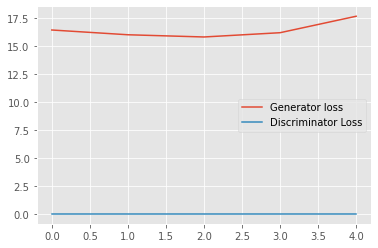

In [ ]:
################### Initialize parameters###############

image_size = 256 # we need to resize image to 128 x 128
batch_size = 4 
workers = 2
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 128 # fixed sample size
epochs = 5 # number of epoch to train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nc = 3 #Number of channels in the training images. For color images this is 3
nz = 125 # Size of z latent vector (i.e. size of generator input)

pretrained = True
saving_image = False

animal = "HORSE"
#animal = "COW"

##################################################
####################### MAIN #####################
##################################################


train_data,train_loader = createGAN_traindataset(batch_size,animal=animal)

training_GAN(nz,device,epochs,train_data,train_loader,animal,saving_image, pretrained)


In [ ]:
%cd

/root


## <b>Printing some generated image saved<b>

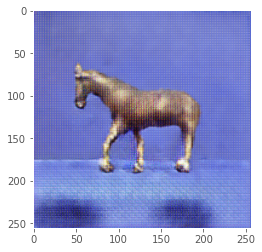

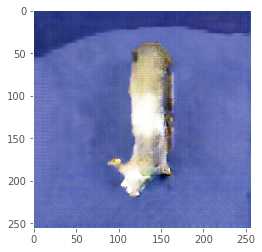

In [ ]:
from PIL import Image

plt.rcParams["axes.grid"] = False
image = Image.open('/content/drive/MyDrive/Project_MV/GAN/EXTRACT/horse/horse_gan17.png')
plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
image = Image.open('/content/drive/MyDrive/Project_MV/GAN/EXTRACT/cow/cow_gan15.png')
plt.imshow(image)
plt.show()


# <b>PART 3 : CycleGAN<b> 
* In this part, we will implement unpaired neural style transfer using CycleGAN argorithm. The goal is to change style between horse and cow in both direction.

#### <b>Create custom data</b>

* We create custom imagedataset class for both class(cow and horse). 

In [ ]:
import os
import glob
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
 
import torch
import torch.nn as nn
 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

In [ ]:
#Custom dataset
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="Train"):
        self.transform = transforms_

        
        if (mode=="Test"):
          self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}/Shape1") + "/*.png")) #to adapt to actual dataset format
          self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}/Shape2") + "/*.png"))
        else: 
          self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}/Cow") + "/*.png")) 
          self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}/Horse") + "/*.png"))
        

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)])
        img_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]) # img_B : sampling randomly

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

### <b>Define transform function</b>

* We use bicubic interpolation to upsample images by multiplying 1.12 and random crop
* RandomHorizontalFlip allows us to have various sides of images

#### <b>Define dataset</b>
* Define train, test dataset according to mode defined
* Dataloader load dataset with batch size 4 and random shuffling data

In [ ]:
%cd /content/

/content


In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),#interpolation upsampling method(bicubic)
    transforms.RandomCrop((256, 256)),#random crop
    transforms.RandomHorizontalFlip(), # As data is single image, we can flip right and left side
    transforms.ToTensor(), #Change into Tensor format
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize 
])

#define dataset
train_dataset = ImageDataset("./drive/MyDrive/data/Project1/ORIGINAL_DATASET", transforms_=transforms_,mode="Train")
val_dataset = ImageDataset("./drive/MyDrive/data/Project1/ORIGINAL_DATASET", transforms_=transforms_,mode="Test")

#dataloader for dataset
train_dataloader_cycleGAN = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader_cycleGAN = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

#load train dataset in gpu
for i, batch in enumerate(train_dataloader_cycleGAN):
  real_A = batch["A"].cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


##<b>Architecture<b>

####<b>Generator<b>
* Generator includes 3 parts 

1.   Encoding part(Convlutional layers)
2.   Transformation part(Residual blocks)
3.   Decoding part(Deconvolution layer + convolutional layer at the end)

* By using residual block(ResNet) we can keep most of the information and get high resolution images

####<b>Discriminator<b>
* Discriminator is made based PatchGAN
* PatchGAN is a role of discriminator in existing GAN, which determines whether it is real or fake by looking at the whole image, which makes it the overlap patch unit of Image.


In [ ]:

# (Residual Block) module definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        # We keep the channel size
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.block(x)


# ResNet based Generator architecture 
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0] # Input image channel : 3

        # Beginning of convolution block layer
        out_channels = 64
        model = [nn.ReflectionPad2d(channels)]
        model.append(nn.Conv2d(channels, out_channels, kernel_size=7))
        model.append(nn.InstanceNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        in_channels = out_channels

        # Downsampling
        for _ in range(2):
            out_channels *= 2
            model.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)) #Width and height reduces as 1/2 
            model.append(nn.InstanceNorm2d(out_channels))
            model.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        # Output: [256 X (1/4 x height) X (1/4 x width)]

        # We use residual blocks between encoder and decoder
        for _ in range(num_residual_blocks):
            model.append(ResidualBlock(out_channels))

        # (Upsampling)
        for _ in range(2):
            out_channels //= 2
            model.append(nn.Upsample(scale_factor=2)) # Width x2 and Height x2
            model.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)) # Same width and height 
            model.append(nn.InstanceNorm2d(out_channels))
            model.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        #Output: [256 X (4 x height) X (4 x width)]

        # Output (Convolution Block) layer
        model.append(nn.ReflectionPad2d(channels))
        model.append(nn.Conv2d(out_channels, channels, kernel_size=7))
        model.append(nn.Tanh())

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # (Convolution Block) Module definition
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)] #Width and height reduces as 1/2 
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            #discriminator leakyReLu helps for generator to update weights
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False), # output: [64 X 128 X 128]
            *discriminator_block(64, 128), # output: [128 X 64 X 64]
            *discriminator_block(128, 256), # output: [256 X 32 X 32]
            *discriminator_block(256, 512), # output: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1) # output: [1 X 16 X 16]
        )
        # final output: [1 X (16times reduced height X (16times reduced width)]

    def forward(self, img):
        return self.model(img)

##<b>Model learning and sampling<b>##
Here We definie extra utility for training 
* Replay buffer : While training GAN, We show generated images to discriminator periodically to stabilize training better
* Learning rate scheduler : We anneal learning rate according to step for better converge
* Weight initialize with Normal distribution : We intitialize generator and discriminator model with mean 0 and std 0.0.2. It helps to prevent gradient exploding/ vanishing problems
* Here 9 residual blocks are used according to CycleGAN paper to have a better resolution (256 x 256)
* We set proper hyper parameters(200 epochs, decay epochs 100epochs, lr = 0.0002)

In [ ]:
# Image buffer class
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    # We insert new images and return the image inserted previously
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            # If buffer is not filled with we return currently inserted data
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            # If buffer is all full we return randomly inserted images before
            else:
                if random.uniform(0, 1) > 0.5: # Probability 50%
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element # We exchange image in buffer버
                else:
                    to_return.append(element)
        return torch.cat(to_return)


# Class definition for : as time passed, we reduce learning rate
class LambdaLR:
    def __init__(self, n_epochs, decay_start_epoch):
        self.n_epochs = n_epochs #total epochs
        self.decay_start_epoch = decay_start_epoch # Epoch starting to reduce learning rate

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


# Function definition for initializing weights 
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) #mean 0 , std 0.02
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
G_BA = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
D_A = Discriminator(input_shape=(3, 256, 256))
D_B = Discriminator(input_shape=(3, 256, 256))

G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

# load weights with previous values
G_AB.load_state_dict(torch.load("./drive/MyDrive/data/Project3/Weights/CycleGAN_G_AB_for_Horse2Cow.pt"))
G_BA.load_state_dict(torch.load("./drive/MyDrive/data/Project3/Weights/CycleGAN_G_BA_for_Horse2Cow.pt"))
D_A.load_state_dict(torch.load("./drive/MyDrive/data/Project3/Weights/CycleGAN_D_A_for_Horse2Cow.pt"))
D_B.load_state_dict(torch.load("./drive/MyDrive/data/Project3/Weights/CycleGAN_D_B_for_Horse2Cow.pt"))

# Initialize weights
#G_AB.apply(weights_init_normal)
#G_BA.apply(weights_init_normal)
#D_A.apply(weights_init_normal)
#D_B.apply(weights_init_normal)

# loss function
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_cycle.cuda()
criterion_identity.cuda()

n_epochs = 200 # Set the epochs for training
decay_epoch = 100 # Set the epochs reducing the learning rate(Every 100 epoch we reduce learning rate)
lr = 0.0002 # Learning rate

# Optimizer function for generator and discriminator
#Adam optimizer is good for GAN trainng
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A  = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# learning rate update and initialize
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)

## <b> Model training <b>
* Total loss = GAN loss + Cycle loss + Identity loss
* By adding identity loss, we change style respecting the original image(preserving color information)

In [ ]:
import time

sample_interval = 50 # We print every sample_interval batch results 

lambda_cycle = 10 # Cycle loss weight
lambda_identity = 5 # Identity loss weight

# Buffer which includes image data generated before 
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader_cycleGAN):
        # Calling model input data
        real_A = batch["A"].cuda()
        real_B = batch["B"].cuda()

        # Make a label for real and fake (1/16 x width, 1/16 x height)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # (real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # (fake): 0

        """ Learning generator : A. """
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss calculation
        loss_identity_A = criterion_identity(G_BA(real_A), real_A)
        loss_identity_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_identity_A + loss_identity_B) / 2

        # GAN loss calculaiton
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), real)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), real)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss calculation
        recover_A = G_BA(fake_B)
        recover_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recover_A, real_A)
        loss_cycle_B = criterion_cycle(recover_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total (loss)
        loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity

        # Update generator
        loss_G.backward()
        optimizer_G.step()

        """ Learning discrimator: A. """
        optimizer_D_A.zero_grad()

        # Real loss: To detect ground truth image as real 
        loss_real = criterion_GAN(D_A(real_A), real)

        # Fake loss: To detect fake images as fake
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)

        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        # Update discriminator
        loss_D_A.backward()
        optimizer_D_A.step()

        """ Learning discriminator : B. """
        optimizer_D_B.zero_grad()

        # Real loss: To detect original image as real
        loss_real = criterion_GAN(D_B(real_B), real)

        # Fake loss: To detect fake images as fake
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)

        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        #pdate discriminator
        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        done = epoch * len(train_dataloader_cycleGAN) + i
        if done % sample_interval == 0:
            G_AB.eval()
            G_BA.eval()
            imgs = next(iter(val_dataloader_cycleGAN)) # extract 5 images and generate
            real_A = imgs["A"].cuda()
            real_B = imgs["B"].cuda()
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            # Grid image generation according to x axis 
            real_A = make_grid(real_A, nrow=4, normalize=True)
            real_B = make_grid(real_B, nrow=4, normalize=True)
            fake_A = make_grid(fake_A, nrow=4, normalize=True)
            fake_B = make_grid(fake_B, nrow=4, normalize=True)
            #Connect each grid images based on the image height
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
            save_image(image_grid, f"./drive/MyDrive/data/Project3/Result/result6_{done}.png", normalize=False)
            print(f"[Done {i}/{len(train_dataloader)}] [Elapsed time: {time.time() - start_time:.2f}s]")

    #learning rate
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    #Every one epoch finish, we print log result 
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G identity loss: {loss_identity.item():.6f}, adv loss: {loss_GAN.item()}, cycle loss: {loss_cycle.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

    #Every one epoch finish, we save model parameters 
    #torch.save(G_AB.state_dict(), "G_AB.pt")
    #torch.save(G_BA.state_dict(), "G_BA.pt")
    #torch.save(D_A.state_dict(), "D_A.pt")
    #torch.save(D_B.state_dict(), "D_B.pt")
    print("Model saved!")

  

[Done 0/11] [Elapsed time: 2.31s]
[Epoch 0/100] [D loss: 0.137508] [G identity loss: 0.037086, adv loss: 0.31543710827827454, cycle loss: 0.041689202189445496] [Elapsed time: 13.78s]
Model saved!
[Epoch 1/100] [D loss: 0.123697] [G identity loss: 0.034200, adv loss: 0.5065151453018188, cycle loss: 0.043534062802791595] [Elapsed time: 26.65s]
Model saved!
[Epoch 2/100] [D loss: 0.185090] [G identity loss: 0.040906, adv loss: 0.3472009003162384, cycle loss: 0.041517555713653564] [Elapsed time: 39.49s]
Model saved!
[Epoch 3/100] [D loss: 0.188975] [G identity loss: 0.039810, adv loss: 0.42743539810180664, cycle loss: 0.04840223491191864] [Elapsed time: 52.36s]
Model saved!
[Done 6/11] [Elapsed time: 62.00s]
[Epoch 4/100] [D loss: 0.214472] [G identity loss: 0.036059, adv loss: 0.6503825187683105, cycle loss: 0.054688166826963425] [Elapsed time: 66.09s]
Model saved!
[Epoch 5/100] [D loss: 0.248096] [G identity loss: 0.035078, adv loss: 0.6863612532615662, cycle loss: 0.04213475063443184] [

In [ ]:
#Save model parameter
torch.save(G_AB.state_dict(), "./drive/MyDrive/data/Project3/Weights/2/CycleGAN_G_AB_for_Horse2Cow.pt")
torch.save(G_BA.state_dict(), "./drive/MyDrive/data/Project3/Weights/2/CycleGAN_G_BA_for_Horse2Cow.pt")
torch.save(D_A.state_dict(), "./drive/MyDrive/data/Project3/Weights/2/CycleGAN_D_A_for_Horse2Cow.pt")
torch.save(D_B.state_dict(), "./drive/MyDrive/data/Project3/Weights/2/CycleGAN_D_B_for_Horse2Cow.pt")
print("Model saved!")

Model saved!


##<b>Display output images<b>
* We extract 5 images and generate
* First row (test dataset- cow), Third row(test dataset-horse)
* Second row(style transferred cow), Forth row(style transferred horse)

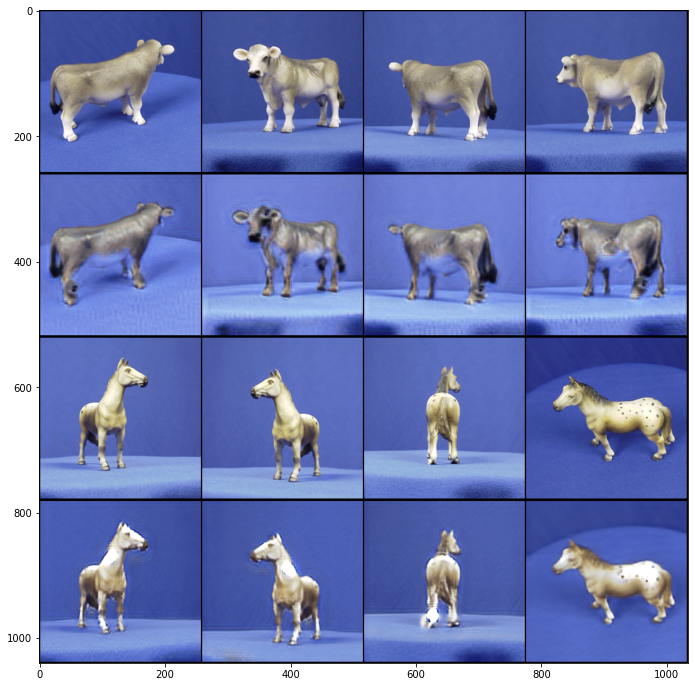

In [ ]:
from PIL import Image

imgs = next(iter(val_dataloader_cycleGAN)) # Extract 5 images and generate
real_A = imgs["A"].cuda()
real_B = imgs["B"].cuda()
fake_B = G_AB(real_A)
fake_A = G_BA(real_B)
# Grid image generation according to x axis 
real_A = make_grid(real_A, nrow=4, normalize=True)
real_B = make_grid(real_B, nrow=4, normalize=True)
fake_A = make_grid(fake_A, nrow=4, normalize=True)
fake_B = make_grid(fake_B, nrow=4, normalize=True)
#Connect each grid images based on the image height
image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
save_image(image_grid, f"./drive/MyDrive/data/Project3/Result/final5.png", normalize=False)

plt.figure(figsize = (12,12))
image = Image.open('./drive/MyDrive/data/Project3/Result/final5.png')

plt.imshow(image)
plt.show()